# <center>Рекомендательная система на основе эмбеддингов для датасета MovieLens</center>

# Первичный анализ и предобработка данных

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import tqdm

## Загрузка данных

In [16]:
movies_df = pd.read_csv("ml-latest\movies.csv", index_col='movieId')
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [17]:
movies_df.shape

(58098, 2)

In [4]:
#tags_df = pd.read_csv('/kaggle/input/grouplens-2018/ml-latest/tags.csv')
#tags_df.head()

In [4]:
ratings_df = pd.read_csv(r"ml-latest\ratings.csv").iloc[:1_000_000]
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000000 non-null  int64  
 1   movieId    1000000 non-null  int64  
 2   rating     1000000 non-null  float64
 3   timestamp  1000000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 30.5 MB


## Обработка датасета с фильмами

In [6]:
genres_list = ['Action', 'Adventure','Animation',"Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
               'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)', 'IMAX']

In [7]:
movies_df['year'] = 0
movies_df['year'] = movies_df['year'].astype(int)

for genre in genres_list:
    movies_df[genre] = 0
    movies_df[genre] = movies_df[genre].astype(int)

Применение one-hot one hot encoding для кодирования жанров

In [8]:
for index, row in tqdm.tqdm(movies_df.iterrows()):
    movieId = index
    title = row.title
    matcher = re.compile('\s*\(\d{4}\)')
    if matcher.search(title) is not None:
        parenthesis_year = matcher.search(title).group(0)
        matcher = re.compile('\s*\d{4}')
        year = matcher.search(parenthesis_year).group(0)
        movies_df.loc[index, 'year'] = int(year)
        movies_df.loc[index, 'title'] = re.sub(r'\s*\(\d{4}\)', "", title)
    
    try:
        genres = row.genres.split('|') 
    except Exception:
        genres = list(row.genres)
    
    for genre in genres:
        movies_df.loc[index, genre] = 1
    

58098it [00:24, 2405.74it/s]


In [9]:
movies_df = movies_df.drop('genres', axis=1)
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 1 to 193886
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               58098 non-null  object
 1   year                58098 non-null  int32 
 2   Action              58098 non-null  int32 
 3   Adventure           58098 non-null  int32 
 4   Animation           58098 non-null  int32 
 5   Children            58098 non-null  int32 
 6   Comedy              58098 non-null  int32 
 7   Crime               58098 non-null  int32 
 8   Documentary         58098 non-null  int32 
 9   Drama               58098 non-null  int32 
 10  Fantasy             58098 non-null  int32 
 11  Film-Noir           58098 non-null  int32 
 12  Horror              58098 non-null  int32 
 13  Musical             58098 non-null  int32 
 14  Mystery             58098 non-null  int32 
 15  Romance             58098 non-null  int32 
 16  Sci-Fi              5

Вычисления средней оценки, стандартного отклонения и числа оценок

In [11]:
ratings_df_grouped = ratings_df.groupby('movieId').agg({'rating': ['mean', 'std', 'count']})
ratings_df_grouped.columns = ['rating_mean', 'rating_std', 'rating_count']
ratings_df_grouped['rating_count'] = ratings_df_grouped['rating_count'].astype(int)
ratings_df_grouped.head()

,rating_mean,rating_std,rating_count
movieId,,,
1,3.891454,0.917794,2469
2,3.231282,0.959175,975
3,3.190355,0.999860,591
4,2.995902,1.031520,122
5,3.032907,1.034132,547


In [12]:
ratings_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 1 to 193861
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating_mean   22031 non-null  float64
 1   rating_std    15140 non-null  float64
 2   rating_count  22031 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 602.4 KB


Если дана одна оценка фильма - стандартное отклонение не определено

In [13]:
ratings_df_grouped[(ratings_df_grouped['rating_std'].isnull()) & (ratings_df_grouped['rating_count'] != 1)]

,rating_mean,rating_std,rating_count
movieId,,,


In [14]:
ratings_df_grouped['rating_std'] = ratings_df_grouped['rating_std'].fillna(0)

In [15]:
movies_df = movies_df.join(ratings_df_grouped)

In [16]:
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,3.891454,0.917794,2469.0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3.231282,0.959175,975.0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,3.190355,0.999860,591.0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,2.995902,1.031520,122.0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3.032907,1.034132,547.0


In [17]:
movies_df['rating_mean'] = movies_df.rating_mean.fillna(movies_df.rating_mean.mean())
movies_df['rating_std'] = movies_df.rating_std.fillna(0)
movies_df['rating_count'] = movies_df.rating_count.fillna(0)

In [18]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 1 to 193886
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               58098 non-null  object 
 1   year                58098 non-null  int32  
 2   Action              58098 non-null  int32  
 3   Adventure           58098 non-null  int32  
 4   Animation           58098 non-null  int32  
 5   Children            58098 non-null  int32  
 6   Comedy              58098 non-null  int32  
 7   Crime               58098 non-null  int32  
 8   Documentary         58098 non-null  int32  
 9   Drama               58098 non-null  int32  
 10  Fantasy             58098 non-null  int32  
 11  Film-Noir           58098 non-null  int32  
 12  Horror              58098 non-null  int32  
 13  Musical             58098 non-null  int32  
 14  Mystery             58098 non-null  int32  
 15  Romance             58098 non-null  int32  
 16  Sci

In [49]:
movies_df.to_csv('ml-latest/movies_mod.csv')

## Обработка датасета с тегами

In [3]:
genome_names = pd.read_csv('ml-latest/genome-tags.csv')
genome_names.tag.values

array(['007', '007 (series)', '18th century', ..., 'wwii', 'zombie',
       'zombies'], dtype=object)

In [6]:
genome_scores = pd.read_csv('ml-latest/genome-scores.csv')
genome_scores = genome_scores.pivot(index='movieId', columns='tagId', values='relevance')

In [9]:
genome_scores.columns = genome_names.tag.values
genome_scores.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575


In [10]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13176 entries, 1 to 187595
Columns: 1128 entries, 007 to zombies
dtypes: float64(1128)
memory usage: 113.5 MB


In [13]:
genome_scores.to_csv('ml-latest/genome-pivot.csv')

## Визуализация данных

Распределение средних оценок фильмов

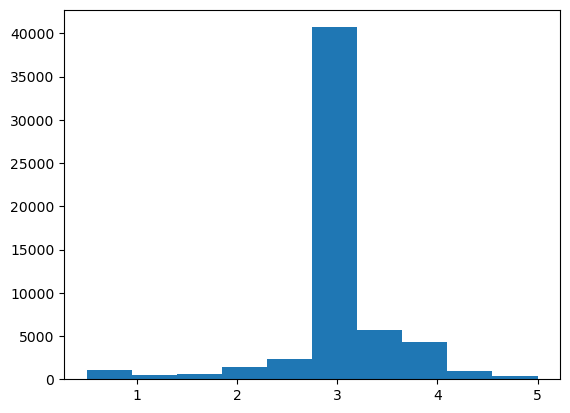

In [27]:
movies_df.rating_mean.hist(bins=10)
plt.grid(False)
plt.show()

Распределение жанров фильмов

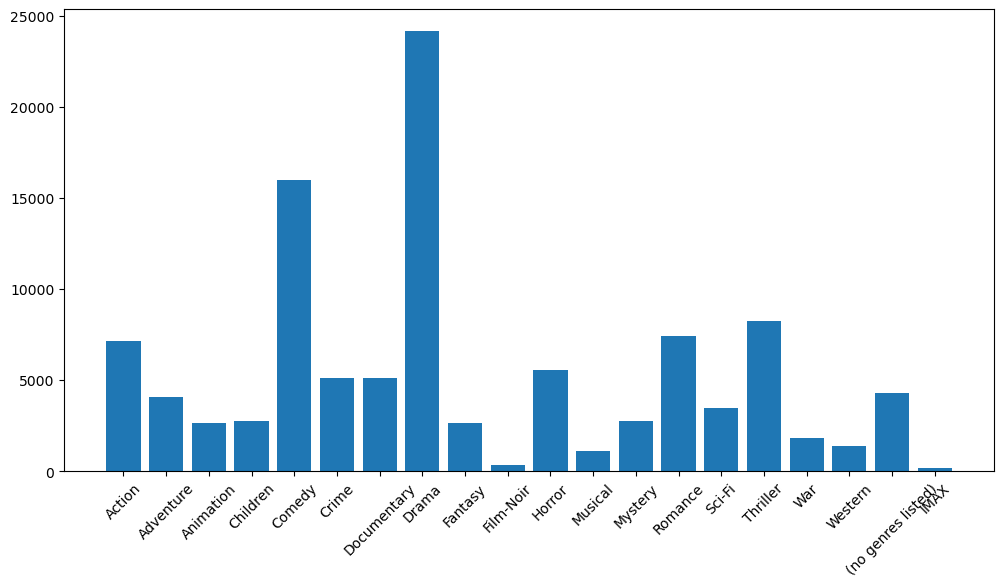

In [47]:
plt.figure(figsize=(12,6))
plt.bar(movies_df[genres_list].sum().index, movies_df[genres_list].sum().values)
plt.xticks(rotation = 45)
plt.show()